In [3]:
!pip install transformers[torch] kaggle scikit-image

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import os
import shutil

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from skimage.io import imread
from PIL import Image
from sklearn.svm import LinearSVC
from transformers import CLIPProcessor, CLIPModel
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.notebook import tqdm
from kaggle.api.kaggle_api_extended import KaggleApi
from random import choice

%matplotlib inline

In [6]:
api = KaggleApi()
api.authenticate()

In [12]:
# kaggle datasets download -d ujjwalchowdhury/yoga-pose-classification
yoga_dl_path = Path("./yoga")
api.dataset_download_files('ujjwalchowdhury/yoga-pose-classification', path=yoga_dl_path, quiet=False, unzip=True)

100%|██████████| 15.0M/15.0M [00:00<00:00, 21.0MB/s]


In [13]:
yoga_data_path = yoga_dl_path / "YogaPoses"
classes = [f.stem for f in yoga_data_path.glob("*") if f.is_dir()]
classes

['Downdog', 'Warrior2', 'Tree', 'Plank', 'Goddess']

Downdog 196 (240, 186, 3)
Warrior2 198 (240, 313, 3)
Tree 198 (240, 181, 3)
Plank 197 (166, 320, 3)
Goddess 199 (240, 320, 3)


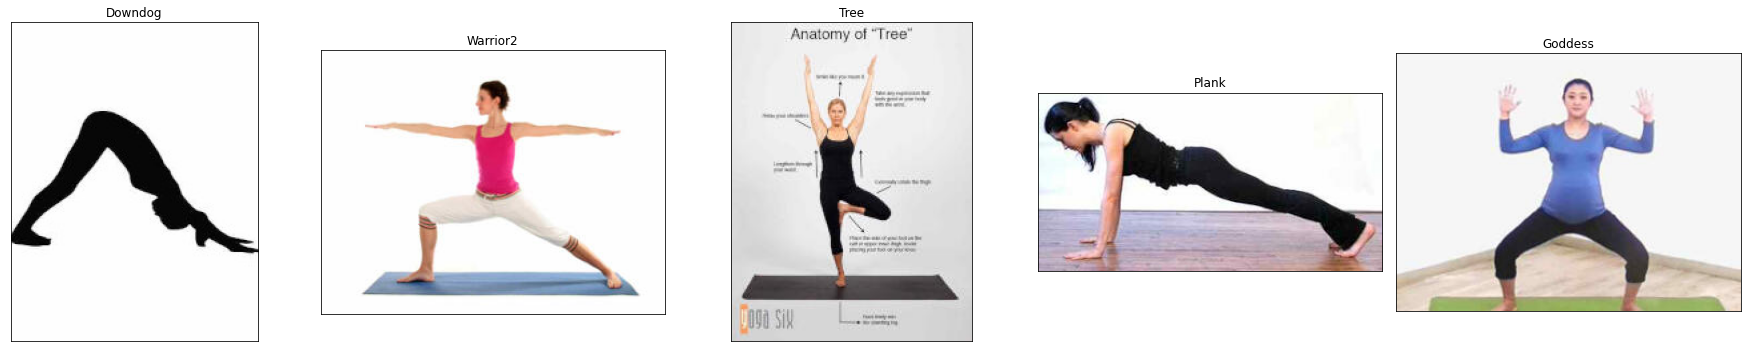

In [14]:
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, cls in enumerate(classes):
    image_paths = list((yoga_data_path / cls).glob("*.jpg"))
    first_image_path = choice(image_paths)
    first_image = imread(first_image_path)
    print(cls, len(image_paths), first_image.shape)
    axes[i].imshow(first_image)
    axes[i].set_title(cls)
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

In [15]:
device = "cuda"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.to(device)

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05, element

In [16]:
processor.feature_extractor

CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}

In [17]:
prompt_set = [[cls + " yoga pose" for cls in classes],
              ["downward dog yoga pose", "warrior two yoga pose", "tree yoga pose", "plank yoga pose", "goddess yoga pose"],
              ["Adho mukha svanasana", "Virabhadrasana II", "Vrikshasana", "Phalakasana", "Utkata Konasana"]]
with torch.no_grad():
    for prompts in prompt_set:
        print(prompts)
        acc_total = 0
        for i, cls in enumerate(classes):
            image_paths = list((yoga_data_path / cls).glob("*.jpg"))
            images = [Image.open(p) for p in image_paths]

            inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to("cuda")

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
            preds = np.bincount(probs.argmax(1), minlength=len(classes))
            acc = preds[i]/len(image_paths)
            print(f"{cls} {preds} {100*acc:.2f}%")
            acc_total += acc
        print(f"Avg accuracy: {acc_total/len(classes)}")
        print()
        
        # print(cls, [classes[idx] for idx in probs.argmax(1)])

['Downdog yoga pose', 'Warrior2 yoga pose', 'Tree yoga pose', 'Plank yoga pose', 'Goddess yoga pose']
Downdog [  7  24   0 102  63] 3.57%
Warrior2 [  0 184   1   2  11] 92.93%
Tree [  0 117   9   0  72] 4.55%
Plank [  0  26   0 169   2] 85.79%
Goddess [  0 142   0   0  57] 28.64%
Avg accuracy: 0.4309523883140699

['downward dog yoga pose', 'warrior two yoga pose', 'tree yoga pose', 'plank yoga pose', 'goddess yoga pose']
Downdog [30 22  0 88 56] 15.31%
Warrior2 [  0 185   1   2  10] 93.43%
Tree [  0 138   9   0  51] 4.55%
Plank [  6  14   0 173   4] 87.82%
Goddess [  0 147   0   0  52] 26.13%
Avg accuracy: 0.4544676651567158

['Adho mukha svanasana', 'Virabhadrasana II', 'Vrikshasana', 'Phalakasana', 'Utkata Konasana']
Downdog [ 41   1  11 143   0] 20.92%
Warrior2 [ 0 68 37 93  0] 34.34%
Tree [  0  51  33 114   0] 16.67%
Plank [ 36   6  11 144   0] 73.10%
Goddess [ 0 58 50 84  7] 3.52%
Avg accuracy: 0.2970850059944917



In [67]:
intel_dl_path = Path("./intel")
# api.dataset_download_files('puneet6060/intel-image-classification', path=intel_dl_path, quiet=False, unzip=True)

In [68]:
intel_data_path = intel_dl_path / "seg_test" / "seg_test"
classes = [f.stem for f in intel_data_path.glob("*") if f.is_dir()]
classes

['buildings', 'sea', 'street', 'mountain', 'glacier', 'forest']

buildings 437 (150, 150, 3)
sea 510 (150, 150, 3)
street 501 (150, 150, 3)
mountain 525 (150, 150, 3)
glacier 553 (150, 150, 3)
forest 474 (150, 150, 3)


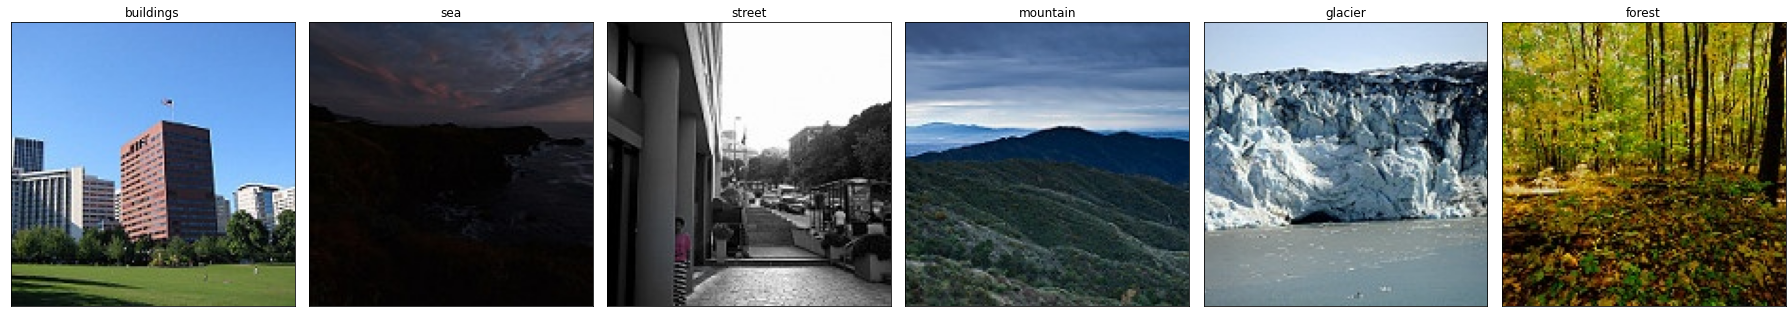

In [69]:
fig, axes = plt.subplots(1, len(classes), figsize=(25, 5))
for i, cls in enumerate(classes):
    image_paths = list((intel_data_path / cls).glob("*.jpg"))
    first_image_path = choice(image_paths)
    first_image = imread(first_image_path)
    print(cls, len(image_paths), first_image.shape)
    axes[i].imshow(first_image)
    axes[i].set_title(cls)
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

In [72]:
prompt_set = [[cls for cls in classes]]
with torch.no_grad():
    for prompts in prompt_set:
        print(prompts)
        acc_total = 0
        for i, cls in enumerate(classes):
            image_paths = list((intel_data_path / cls).glob("*.jpg"))
            images = [Image.open(p) for p in image_paths]

            inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to("cuda")

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
            preds = np.bincount(probs.argmax(1), minlength=len(classes))
            acc = preds[i]/len(image_paths)
            print(f"{cls} {preds} {100*acc:.2f}%")
            acc_total += acc
        print(f"Avg accuracy: {acc_total/len(classes)}")
        print()
        

['buildings', 'sea', 'street', 'mountain', 'glacier', 'forest']


RuntimeError: CUDA out of memory. Tried to allocate 986.00 MiB (GPU 0; 7.80 GiB total capacity; 4.81 GiB already allocated; 668.31 MiB free; 6.11 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [57]:
import shutil
fruit_dl_path = Path("./fruits")
api.dataset_download_files('moltean/fruits', path=fruit_dl_path, quiet=False, unzip=True)
fruit_root_folder = fruit_dl_path / "fruits-360-original-size" / "fruits-360-original-size"
for folder in ["Training", "Validation", "Test"]:
    for sub_folder in (fruit_root_folder / folder).glob("*"):
        cls = "_".join(sub_folder.stem.split("_")[:-1])
        os.makedirs(fruit_root_folder / folder / cls, exist_ok=True)
        shutil.move(sub_folder, fruit_root_folder / folder / cls / sub_folder.stem)

100%|██████████| 1.28G/1.28G [01:00<00:00, 22.9MB/s]


In [58]:
fruit_data_path = fruit_dl_path / "fruits-360-original-size" / "fruits-360-original-size" / "Test"
classes = [f.stem for f in fruit_data_path.glob("*") if f.is_dir()]
classes

['cucumber',
 'zucchini',
 'apple_red_delicios',
 'apple_braeburn',
 'pear',
 'carrot',
 'cabbage_white',
 'apple_granny_smith',
 'apple_golden',
 'apple_crimson_snow',
 'apple',
 'zucchini_dark',
 'apple_red_yellow',
 'eggplant_violet',
 'apple_red',
 'apple_pink_lady',
 'apple_hit',
 'apple_rotten']

apple_granny_smith 160 (446, 475, 3)
apple_red_yellow 154 (323, 332, 3)
zucchini 80 (1011, 281, 3)
carrot 50 (665, 186, 3)
zucchini_dark 80 (830, 210, 3)


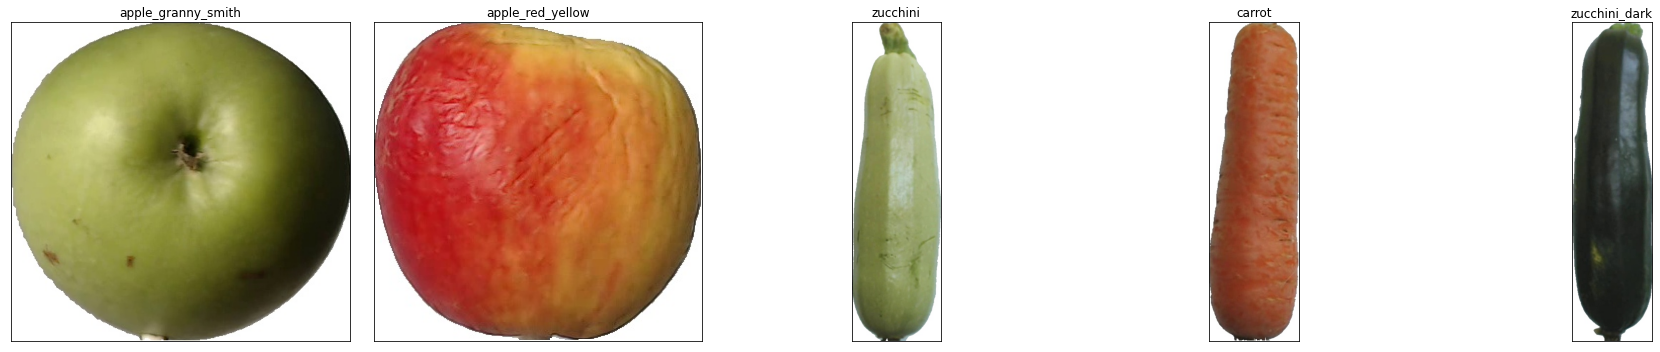

In [59]:
plt_classes = list(np.random.choice(classes, size=5))
fig, axes = plt.subplots(1, len(plt_classes), figsize=(25, 5))
for i, cls in enumerate(plt_classes):
    image_paths = list((fruit_data_path / cls).glob("**/*.jpg"))
    first_image_path = choice(image_paths)
    first_image = imread(first_image_path)
    print(cls, len(image_paths), first_image.shape)
    axes[i].imshow(first_image)
    axes[i].set_title(cls)
    axes[i].axes.xaxis.set_visible(False)
    axes[i].axes.yaxis.set_visible(False)
fig.tight_layout()
fig.show()

In [62]:
prompt_set = [[" ".join(cls.split("_")) for cls in classes]]
with torch.no_grad():
    for prompts in prompt_set:
        print(prompts)
        acc_total = 0
        for i, cls in enumerate(classes):
            image_paths = list((fruit_data_path / cls).glob("**/*.jpg"))
            images = [Image.open(p) for p in image_paths]

            inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True).to("cuda")

            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            probs = logits_per_image.softmax(dim=1).cpu().numpy()
            preds = np.bincount(probs.argmax(1), minlength=len(classes))
            acc = preds[i]/len(image_paths)
            print(f"{cls} {preds} {100*acc:.2f}% {classes[preds.argmax()]}")
            acc_total += acc
        print(f"Avg accuracy: {acc_total/len(classes)}")
        print()

['cucumber', 'zucchini', 'apple red delicios', 'apple braeburn', 'pear', 'carrot', 'cabbage white', 'apple granny smith', 'apple golden', 'apple crimson snow', 'apple', 'zucchini dark', 'apple red yellow', 'eggplant violet', 'apple red', 'apple pink lady', 'apple hit', 'apple rotten']
cucumber [ 15 116   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0] 11.45% zucchini
zucchini [38 38  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0] 47.50% cucumber
apple_red_delicios [  0   0   0   0   6   0   0   0   0 133   0   0   0   0   3   0   0   8] 0.00% apple_crimson_snow
apple_braeburn [ 0  0  0 36  0  0  0  0  0  1  0  0  0  0 77  0  0 46] 22.50% apple_red
pear [  0   0   0   0 233   0   0   1   0   0   0   0   0   0   0   0   0   0] 99.57% pear
carrot [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0  0  0  0] 100.00% carrot
cabbage_white [ 6  0  0  0  0  0 34  1  0  0  0  0  0  0  0  0  0  6] 72.34% cabbage_white
apple_granny_smith [ 1  0  0  0 81  0  0 43  0  0  0  0  0  0  0  0 

In [71]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14-336")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14-336")
model.to(device)
model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, element

In [64]:
processor.feature_extractor

CLIPFeatureExtractor {
  "crop_size": 336,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 336
}